In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [ ]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4
moving_avg_clusters= {
  "cluster0": [],
  "cluster1": [],
  "cluster2": [],
  "cluster3": [],
  "clusterall": [],
}

# Dynamic Pricing with Reinforcement Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_byclusters_train2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_byclusters_train.npy", allow_pickle=True)
df_byclusters_val2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_byclusters_val.npy", allow_pickle=True)

In [ ]:
print("\n***************************************************\nTraining\n***************************************************\n")
df_byclusters_train=[]
for df in df_byclusters_train2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_train.append(df)
print("\n***************************************************\nValidation\n***************************************************\n")
df_byclusters_val=[]
for df in df_byclusters_val2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_val.append(df)


***************************************************
Training
***************************************************

------------------------------------------------------------------------
Max Purchase Amount: 1660.5 Min Purchase Amount: 34.0
Max List Price: 1800.0 Min List Price: 37.66666666666666
Max Rate: 5.0 Min Rate: 2.5
Max Feature Score: 1.6416480998083987 Min Feature Score: 0.469892026578073
Max Room Count: 488.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase Amount: 1610.0 Min Purchase Amount: 235.26315789473685
Max List Price: 1788.8333333333333 Min List Price: 312.7368421052632
Max Rate: 4.5 Min Rate: 4.5
Max Feature Score: 2.2538542161050463 Min Feature Score: 1.7156698058206916
Max Room Count: 412.001 Min Room Count: 0.001
------------------------------------------------------------------------
----------------------------------------------

### UTILITY FUNCTIONS

In [ ]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [ ]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [ ]:
def draw(moving_avg,moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation.reset_index()
    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()
    

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [ ]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [ ]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [ ]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

In [ ]:
moving_avg_clusters= {
  "cluster0": [],
  "cluster1": [],
  "cluster2": [],
  "cluster3": [],
  "clusterall": [],
}

### DRAW AND PRINT METRICS

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


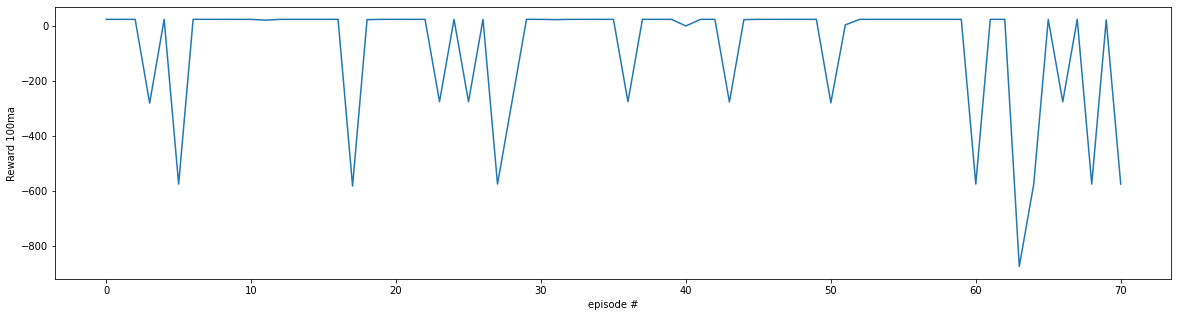

<Figure size 1440x360 with 0 Axes>

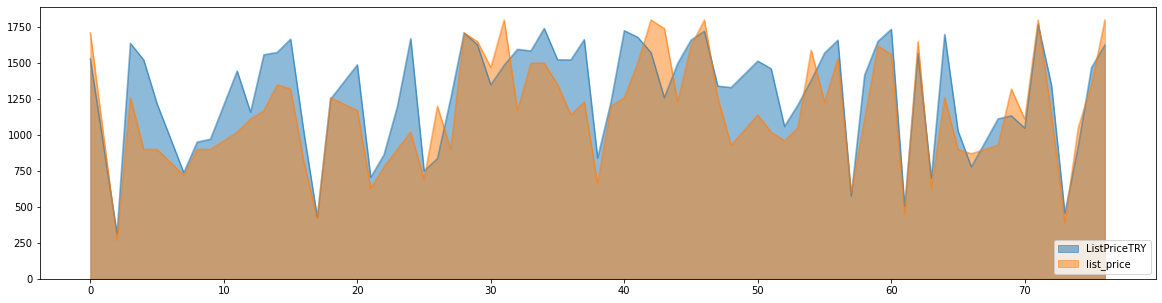

All Dataset


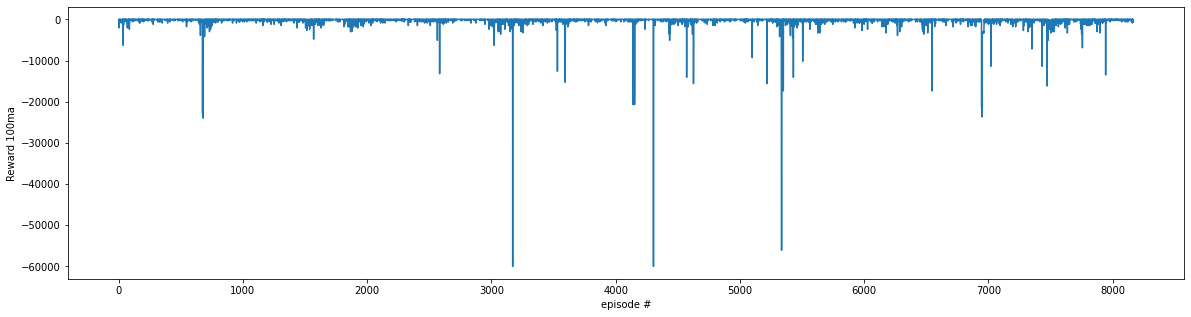

<Figure size 1440x360 with 0 Axes>

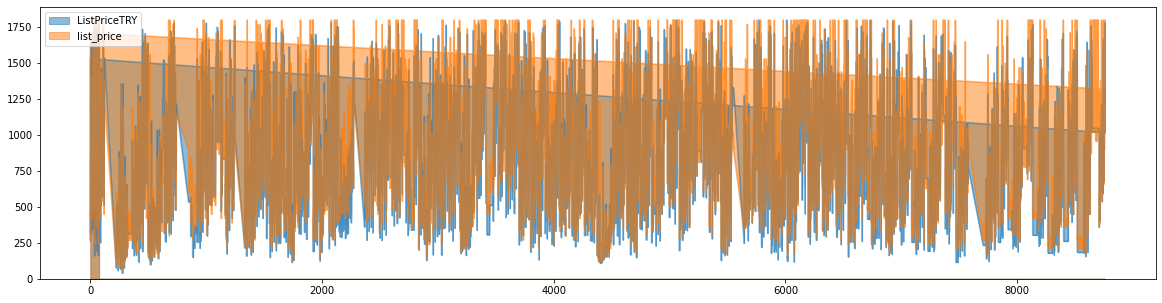



\|
*Number of Sales:  71
*Mean Absolute Error:  204.04557905751798
*Mean Absolute Percentage Error  15.314063334925965
*Mean of Recommended List Prices: 1167.4647887323943
*Mean of Original List Prices: 1292.8753992464058
*Standard Deviation of Recommended List Prices: 379.46472943517665
*Standard Deviation of Original List Prices: 380.4376275822023
|
*Number of Sales:  8166
*Mean Absolute Error:  128.16138393828894
*Mean Absolute Percentage Error  20.258992942598887
*Mean of Recommended List Prices: 836.6348273328435
*Mean of Original List Prices: 766.397331603822
*Standard Deviation of Recommended List Prices: 419.5598143902801
*Standard Deviation of Original List Prices: 414.61779947017
|
*Number of Sales:  8095
*Mean Absolute Error:  127.49581533378426
*Mean Absolute Percentage Error  20.302364159664336
*Mean of Recommended List Prices: 833.7331686226065
*Mean of Original List Prices: 761.7796734441401
*Standard Deviation of Recommended List Prices: 418.7609807955443
*Standard De

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


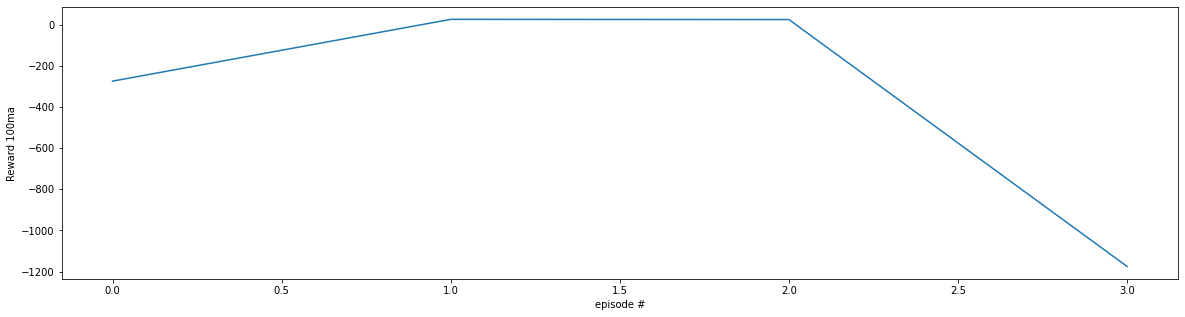

<Figure size 1440x360 with 0 Axes>

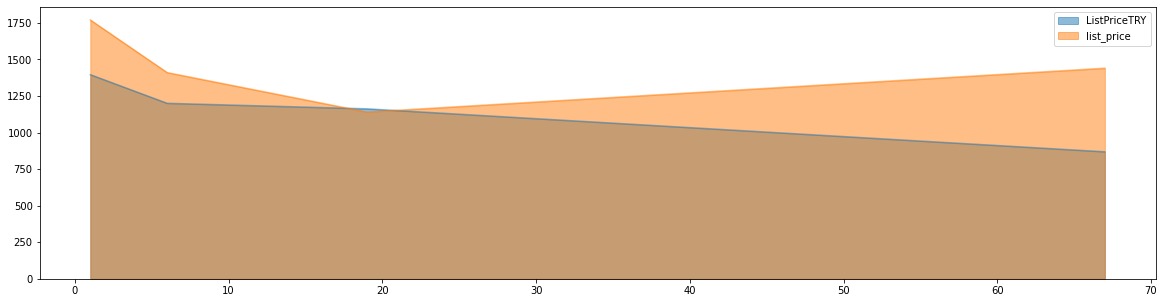

All Dataset


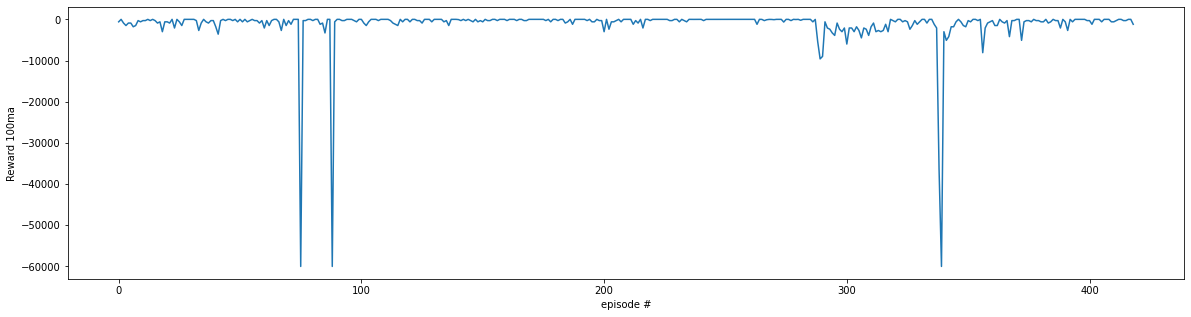

<Figure size 1440x360 with 0 Axes>

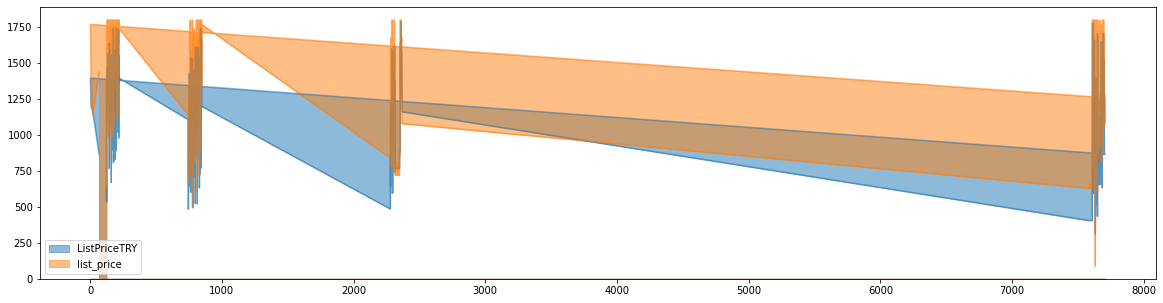



\|
*Number of Sales:  4
*Mean Absolute Error:  294.48522727272723
*Mean Absolute Percentage Error  28.008920046663967
*Mean of Recommended List Prices: 1440.0
*Mean of Original List Prices: 1156.6397727272727
*Standard Deviation of Recommended List Prices: 258.0697580112788
*Standard Deviation of Original List Prices: 217.7487521313316
|
*Number of Sales:  419
*Mean Absolute Error:  199.98971688426013
*Mean Absolute Percentage Error  22.661515092625265
*Mean of Recommended List Prices: 1231.002386634845
*Mean of Original List Prices: 1055.5490249388106
*Standard Deviation of Recommended List Prices: 403.2018354248705
*Standard Deviation of Original List Prices: 380.9556844652663
|
*Number of Sales:  415
*Mean Absolute Error:  199.0789167841303
*Mean Absolute Percentage Error  22.60997384005622
*Mean of Recommended List Prices: 1228.987951807229
*Mean of Original List Prices: 1054.5746562854276
*Standard Deviation of Recommended List Prices: 404.0219745176467
*Standard Deviation of Or

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


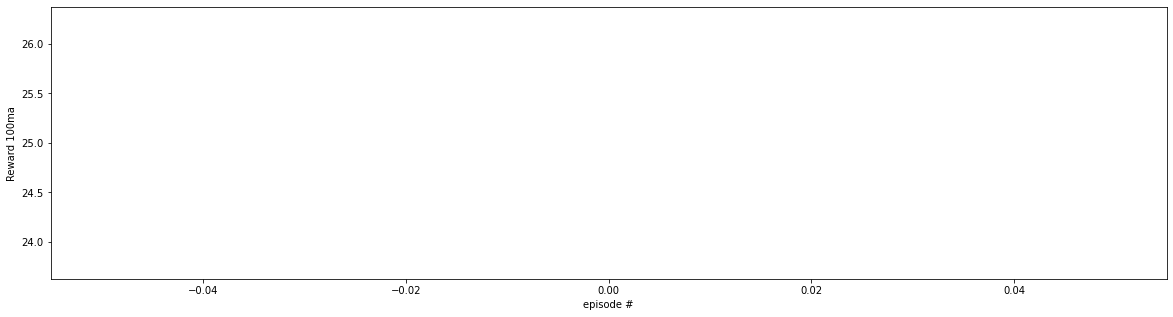

<Figure size 1440x360 with 0 Axes>

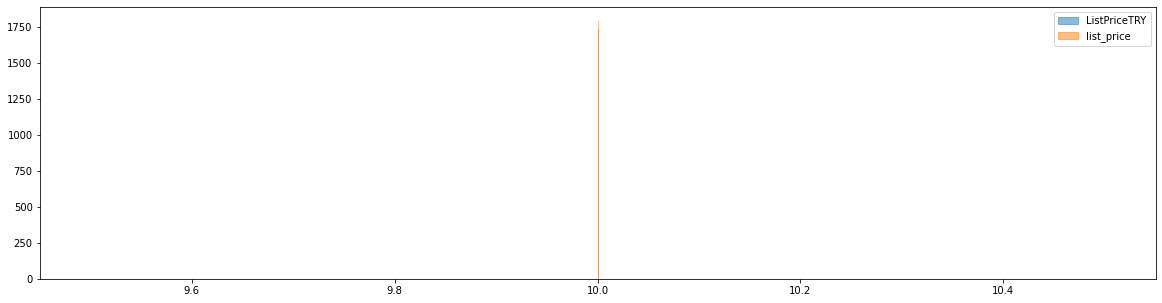

All Dataset


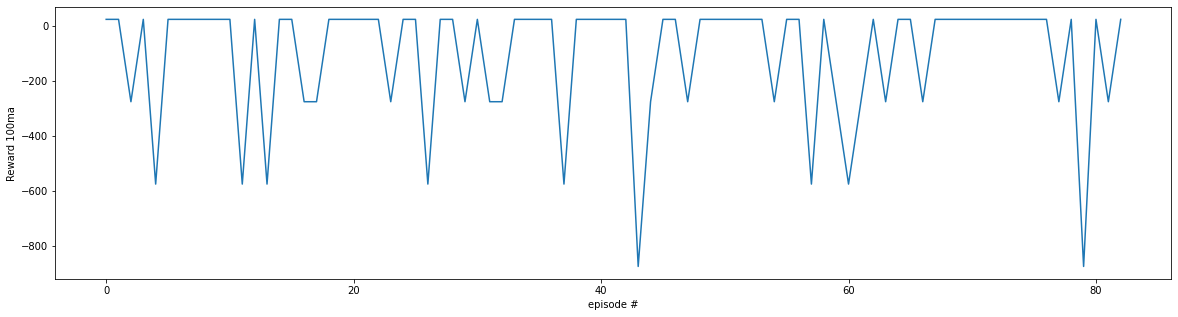

<Figure size 1440x360 with 0 Axes>

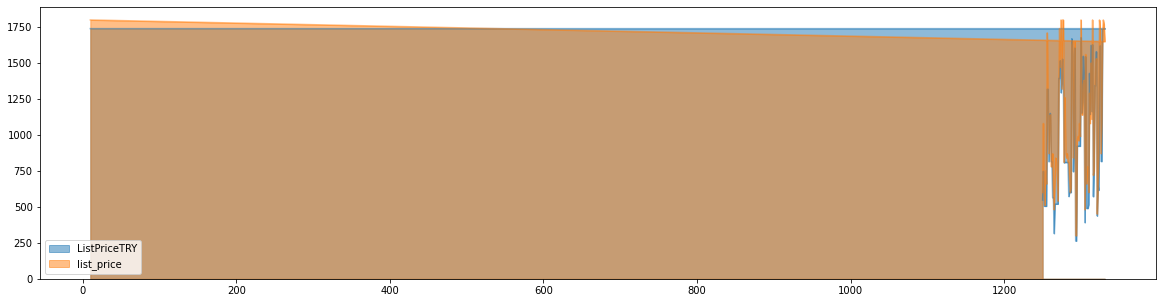



\|
*Number of Sales:  1
*Mean Absolute Error:  60.33333333333326
*Mean Absolute Percentage Error  3.468097336654527
*Mean of Recommended List Prices: 1800.0
*Mean of Original List Prices: 1739.6666666666667
*Standard Deviation of Recommended List Prices: nan
*Standard Deviation of Original List Prices: nan
|
*Number of Sales:  83
*Mean Absolute Error:  127.16162547204081
*Mean Absolute Percentage Error  16.092759426789957
*Mean of Recommended List Prices: 1080.0
*Mean of Original List Prices: 985.7740150784481
*Standard Deviation of Recommended List Prices: 440.50968262661934
*Standard Deviation of Original List Prices: 445.69043697077126
|
*Number of Sales:  82
*Mean Absolute Error:  127.97660464446408
*Mean Absolute Percentage Error  16.246718720572094
*Mean of Recommended List Prices: 1071.219512195122
*Mean of Original List Prices: 976.5802022542014
*Standard Deviation of Recommended List Prices: 435.85134583244854
*Standard Deviation of Original List Prices: 440.4429855024492


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


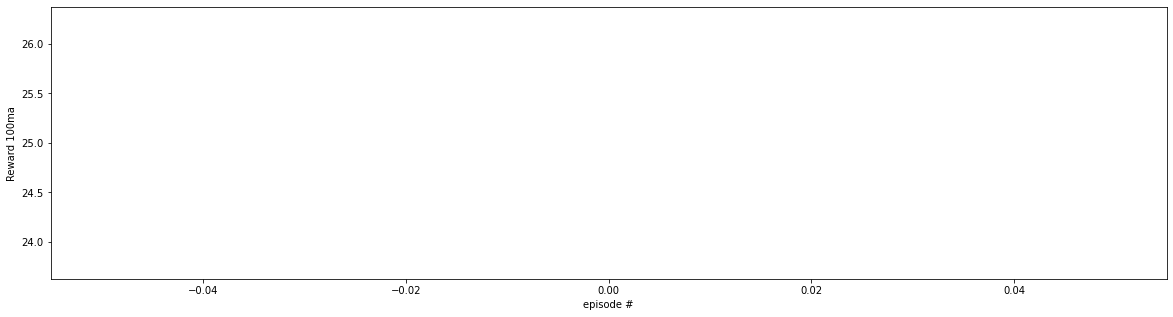

<Figure size 1440x360 with 0 Axes>

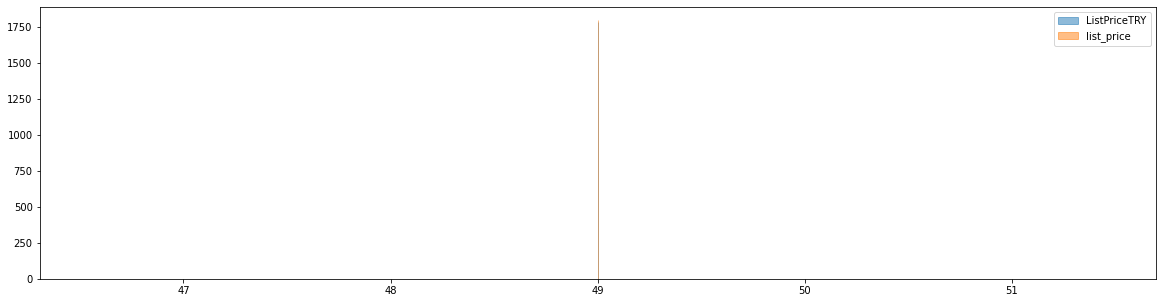

All Dataset


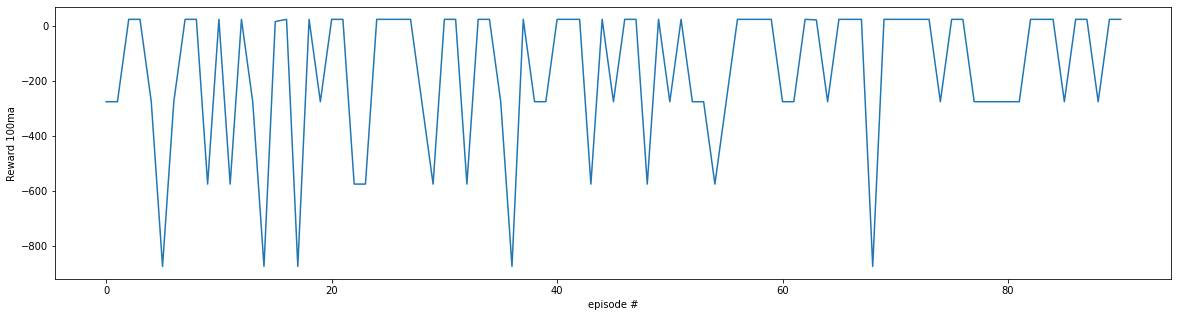

<Figure size 1440x360 with 0 Axes>

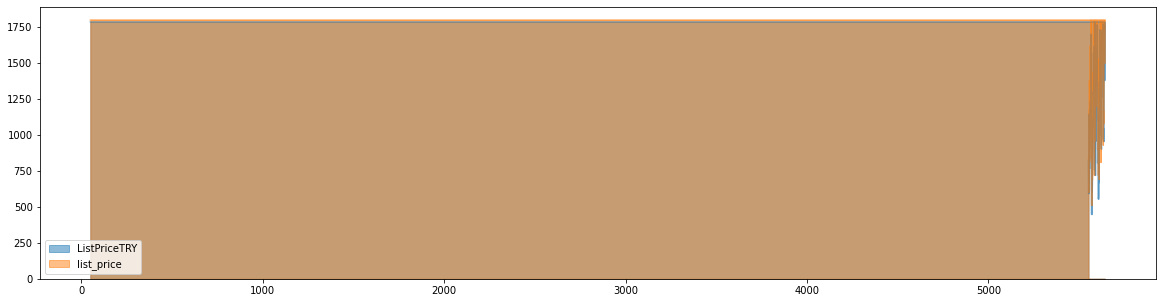



\|
*Number of Sales:  1
*Mean Absolute Error:  13.75
*Mean Absolute Percentage Error  0.7697690692792162
*Mean of Recommended List Prices: 1800.0
*Mean of Original List Prices: 1786.25
*Standard Deviation of Recommended List Prices: nan
*Standard Deviation of Original List Prices: nan
|
*Number of Sales:  91
*Mean Absolute Error:  163.67945392306683
*Mean Absolute Percentage Error  15.439384527274166
*Mean of Recommended List Prices: 1313.4065934065934
*Mean of Original List Prices: 1176.399801140366
*Standard Deviation of Recommended List Prices: 371.88176071978035
*Standard Deviation of Original List Prices: 350.52208280168105
|
*Number of Sales:  90
*Mean Absolute Error:  165.34533674443423
*Mean Absolute Percentage Error  15.60238025458522
*Mean of Recommended List Prices: 1308.0
*Mean of Original List Prices: 1169.6236878197035
*Standard Deviation of Recommended List Prices: 370.3511846882632
*Standard Deviation of Original List Prices: 346.44042354279225
Validation


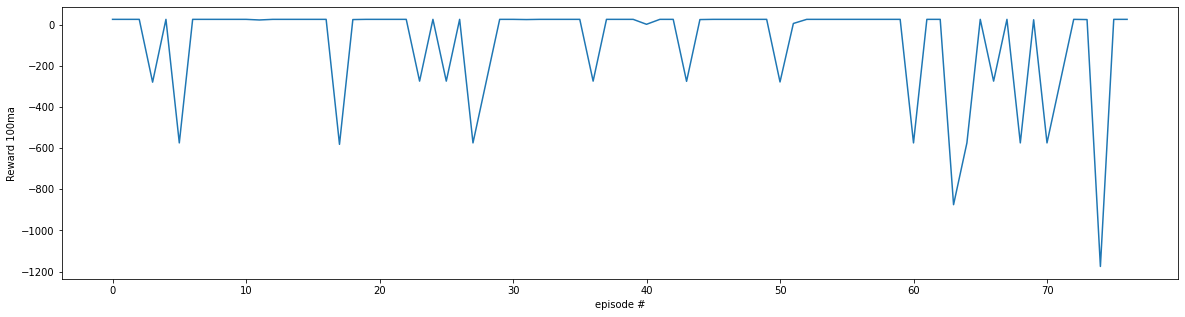

<Figure size 1440x360 with 0 Axes>

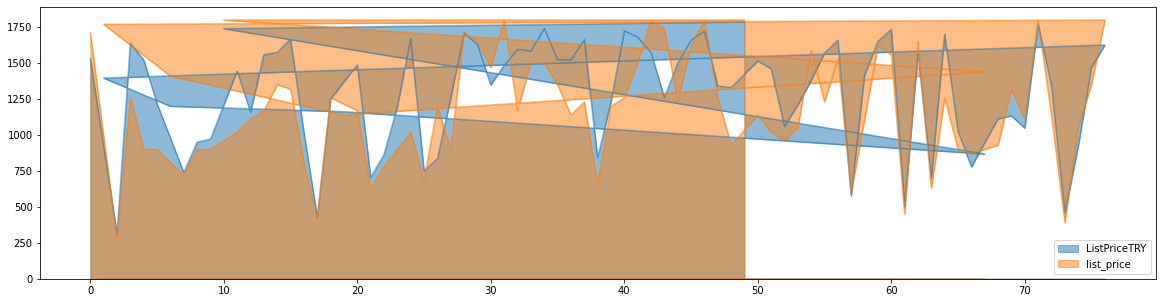

All Dataset


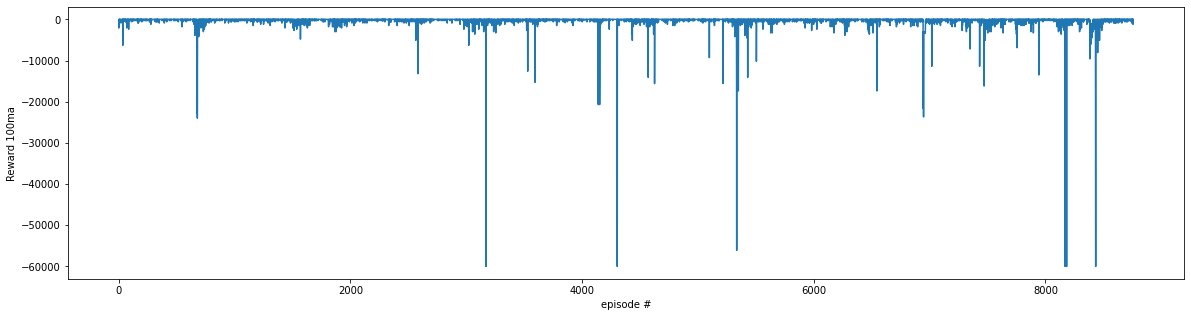

<Figure size 1440x360 with 0 Axes>

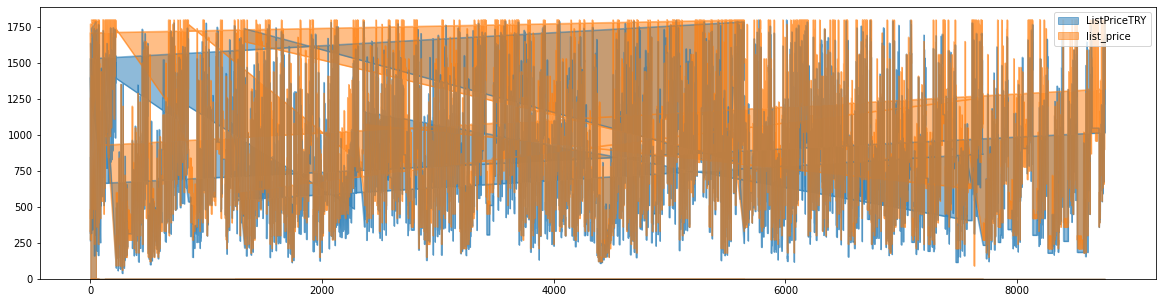



\|
*Number of Sales:  77
*Mean Absolute Error:  204.40597864296126
*Mean Absolute Percentage Error  15.63080575808225
*Mean of Recommended List Prices: 1198.051948051948
*Mean of Original List Prices: 1298.0081701827346
*Standard Deviation of Recommended List Prices: 385.6745251778437
*Standard Deviation of Original List Prices: 376.7728562697772
|
*Number of Sales:  8759
*Mean Absolute Error:  131.95693547616747
*Mean Absolute Percentage Error  20.284369701732814
*Mean of Recommended List Prices: 862.7594474255052
*Mean of Original List Prices: 786.5677904419981
*Standard Deviation of Recommended List Prices: 429.87204532816304
*Standard Deviation of Original List Prices: 419.6582362800511
|
*Number of Sales:  8682
*Mean Absolute Error:  131.3143904031609
*Mean Absolute Percentage Error  20.325641807660148
*Mean of Recommended List Prices: 859.7857636489288
*Mean of Original List Prices: 782.0318644756267
*Standard Deviation of Recommended List Prices: 429.0930152651979
*Standard De

In [ ]:
moving_avg_byclusters_train = []
moving_avg_byclusters_val = []

for i in range(4):
    q_table = q_table_main.copy()
    df_byclusters_train[i].reset_index()
    df_byclusters_train[i], moving_avg_train = RL_proposed(df_byclusters_train[i].shape[0], epsilon, df_byclusters_train[i], q_table)

    moving_avg_byclusters_train.append(moving_avg_train)

    df_byclusters_val[i].reset_index()
    df_byclusters_val[i], moving_avg_val = RL_proposed(df_byclusters_val[i].shape[0], epsilon, df_byclusters_val[i], q_table)

    moving_avg_byclusters_val.append(moving_avg_val)

    moving_avg_clusters[list(moving_avg_clusters.keys())[i]] =[moving_avg_train, moving_avg_val]

    draw(moving_avg_train,
         moving_avg_val, 
         np.concatenate([moving_avg_train, moving_avg_val]), 
         df_byclusters_train[i],  
         df_byclusters_val[i])
draw(np.concatenate(moving_avg_byclusters_train),
     np.concatenate(moving_avg_byclusters_val), 
     np.concatenate([np.concatenate(moving_avg_byclusters_train),np.concatenate(moving_avg_byclusters_val)]), 
     pd.concat(df_byclusters_train),
     pd.concat(df_byclusters_val))

In [ ]:
moving_avg_cluster = {}
moving_avg_cluster['cluster1'] = moving_avg_clusters['cluster0']
moving_avg_cluster['cluster0'] = moving_avg_clusters['cluster1']
moving_avg_cluster['cluster2'] = moving_avg_clusters['cluster2']
moving_avg_cluster['cluster3'] = moving_avg_clusters['cluster3']
moving_avg_cluster['clusterall'] = moving_avg_clusters['clusterall']

In [ ]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_clusters.npy',moving_avg_cluster)